*PyPlr* and Pupil Core
==========================
*PyPlr* was developed against [Pupil Core](https://pupil-labs.com/products/core/)—an affordable, open-source, versatile, ..., research-grade eye tracking ecosystem with high sampling rates, precise model-based 3D estimation of pupil size, and many other features which make it well-suited to our application (see [Kassner et al., 2014](https://arxiv.org/abs/1405.0006), for a detailed overview of the system). In particular, real-time data streaming with the forward facing World Camera allows us to timestamp the onset of light stimuli with good temporal accuracy, which opens the door to integration with virtually any light source given a suitable geometry.

The best place to start learning more about Pupil Core is on the [Pupil Labs website](https://docs.pupil-labs.com/core/), but the features most relevant to *PyPlr* are:

* [Pupil Capture](https://docs.pupil-labs.com/core/software/pupil-capture/#world-window)—Software to interface with a Pupil Core headset.
* [Pupil Player](https://docs.pupil-labs.com/core/software/pupil-player/#load-a-recording)—Software for visualising and exporting data.
* [Pupil Core Network API](https://docs.pupil-labs.com/developer/core/network-api/)—Fast and reliable real-time communication and data streaming with [ZeroMQ](https://zeromq.org/) (an open source universal messaging library) and [MessagePack](https://msgpack.org/index.html) (a binary format for computer data interchange).

*PyPlr*'s `pupil.py` module
---------------------------
*PyPlr* has a module called *pupil.py* which facilitates working with the Pupil Core Network API by wrapping all of the tricky ZeroMQ and MessagePack stuff into a device class called `PupilCore()`. This class has a `.command(...)` method which gives convenient access to all of the commands available via [Pupil Remote](https://docs.pupil-labs.com/developer/core/network-api/#pupil-remote). With Pupil Capture already running, it is easy to make a short recording:

In [2]:
import sys
sys.path.insert(0, '../')

In [3]:
from time import sleep
from pyplr.pupil import PupilCore

p = PupilCore()
p.command('R our_recording')
sleep(10)
p.command('r')

'OK'

Annotations and notifications
-----------------------------
To extract experimental events and calculate time-critical PLR parameters (e.g., constriction latency, time-to-peak constriction) we need a reliable indication in the pupil data of the time at which a light stimulus was actually administered. The Pupil Labs [Annotation Capture](https://docs.pupil-labs.com/core/software/pupil-capture/#annotations) plugin helps us with this. The plugin allows timestamps to be marked with a label, which is basically the same as sending a 'trigger', 'message', or 'event marker'. Annotations can be made programmatically with `PupilCore().new_annotation(...)` and sent using `PupilCore().send_annotation(...)`. It's important to make sure that the Annotation Capture plugin has been enabled, otherwise the annotations won't be captured. You can do this manually in the Pupil Capture GUI or programmatically by sending a [notification message](https://docs.pupil-labs.com/developer/core/network-api/#notification-message), which is a special kind of message that the Pupil software uses to coordinate all activities. The following example shows how to enable the Annotation Capture plugin with a notification and then sends an annotation with the label `'my_event'` halfway through a 10 second recording:

In [12]:
from pyplr.pupil import new_annotation

p = PupilCore()
p.notify({'subject': 'start_plugin',
          'name': 'Annotation_Capture',
          'args': {}
          }) 
p.command('R our_recording')
sleep(5.)
annotation = p.new_annotation(label='my_event',
                              custom_fields={'whatever':'info',
                                             'you':'want'})
p.send_annotation(annotation)
sleep(5.)
p.command('r')

'OK'

Once the recording is finished, we can open it with Pupil Player and use the [Annotation Player](https://docs.pupil-labs.com/core/software/pupil-player/#annotation-export) plugin to view and export the annotations to CSV format. Any custom labels assigned to the annotation will be included as a column in the exported CSV file. By default, the timestamp of an annotation made with the `.new_annotation(...)` method will be the current Pupil time at the time of creation (corrected for transmission delay), but this can be overridden at a later point if desired. 

As for notifications, they can be used for all kinds of things, but there is no single exhaustive document. The best way to find out what options you can manipulate with a notification is to open [the codebase](https://github.com/pupil-labs/pupil) and search for `.notify_all(` and `def on_notify(`. 

Getting pupil data in real-time
-------------------------------
The Pupil Capture software continuously generates pupil data with the camera frames it receives from a Pupil Core headset and makes them available via the [IPC backbone](https://docs.pupil-labs.com/developer/core/network-api/#reading-from-the-ipc-backbone). `PupilCore()` has a `.pupil_grabber(...)` method which simplifies access to these data. Just specify the topic of interest and how long you want to spend grabbing data:

In [58]:
p = PupilCore()
future = p.pupil_grabber(topic='pupil.1.3d', seconds=10)

Grabbing 10 seconds of pupil.1.3d
PupilGrabber done grabbing 10 seconds of pupil.1.3d


Crucially, `.pupil_grabber(...)` does its work in a thread using Python's `concurrent.futures` framework, returning a `Future` object that grants access to the data once the thread has concluded:

In [63]:
data = future.result()
data[0]

{'id': 1,
 'topic': 'pupil.1.3d',
 'method': 'pye3d 0.0.4 real-time',
 'norm_pos': [0.5655694294190798, 0.51342567952097],
 'diameter': 23.99705423825568,
 'confidence': 1.0,
 'timestamp': 680912.412263,
 'sphere': {'center': [9.598701857495012,
   3.0952797661161284,
   48.33511012600127],
  'radius': 10.392304845413264},
 'projected_sphere': {'center': [152.30855744470296, 114.17403946238872],
  'axes': [145.18160935143484, 145.18160935143484],
  'angle': 0.0},
 'circle_3d': {'center': [2.1432373874528103,
   -0.12500974739534687,
   41.850838001459735],
  'normal': [-0.7174024031187592, -0.3098725029157299, -0.6239493761004736],
  'radius': 1.555966130450642},
 'diameter_3d': 2.801000186781173,
 'ellipse': {'center': [108.58933044846333, 93.42226953197378],
  'axes': [17.461405955457835, 23.99705423825568],
  'angle': 24.7916119699982},
 'location': [108.58933044846333, 93.42226953197378],
 'model_confidence': 1.0,
 'theta': 1.885855258683357,
 'phi': -2.425752871347941}

The data is returned as a list of dictionaries, with each dictionary representing a single [data point](https://docs.pupil-labs.com/developer/core/overview/#timing-data-conventions). With a simple helper function we can organise the whole lot and inspect the pupil timecourse:

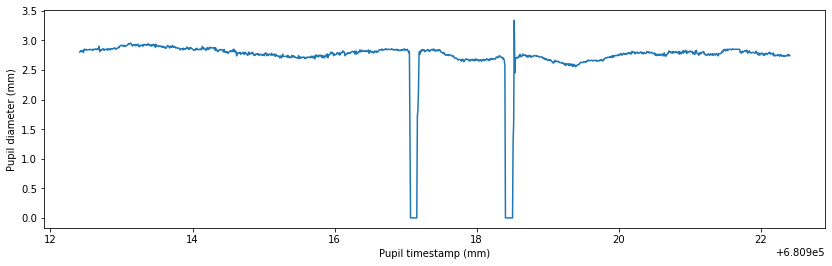

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

def unpack_data_pandas(data):
    return (pd.DataFrame(data)
              .set_index('timestamp')) 

data = unpack_data_pandas(data)
ax = data['diameter_3d'].plot(figsize=(14,4))
ax.set_ylabel('Pupil diameter (mm)')
ax.set_xlabel('Pupil timestamp (mm)')

Timestamping a light stimulus
-----------------------------
The simplest way to timestamp a light stimulus would be to control the light source programatically and send an annotation as close as possible to when we change the status of the light:

```Python
p = PupilCore()
p.command('R')
sleep(5.)
annotation = p.new_annotation('LIGHT_ON')
p.send_annotation(annotation)
my_light.on() # turn hypothetical light source on
sleep(1.)
my_light.off() # now turn it off
sleep(5.)
p.command('r')
```

But in reality this will be problematic as the light source will have a latency of its own, which is difficult to reference. In fact, our light source takes commands via generic HTTP requests and has a variable response time on the order of a few hundred miliseconds. Given that we may want to calculate pupil constriction latency to a light stimulus, which is typically around 200-300 ms, this variable latency is unacceptable.

To solve the issue and to make it easy to integrate *PyPlr* and Pupil Core with any light source, we developed a method called `.light_stamper(...)`. This method uses real-time data from the forward facing World Camera to timestamp light onsets with a level of accuracy that is limited only by the Pupil software's ability to synchronise the eye and world camera frames.

In [5]:
p = PupilCore()
p.notify({'subject': 'start_plugin',
          'name': 'Annotation_Capture',
          'args': {}
         })
p.notify({'subject':'frame_publishing.set_format',
          'format':'bgr'})
p.command('R our_recording')
sleep(5.)
annotation = new_annotation(label='LIGHT_ON')
timeout = 10
lst_future = p.lightstamper(annotation=annotation,
                            threshold=15,
                            timeout=timeout,
                            subscription='frame.world')
sleep(timeout)
p.command('r')
print(lst_future.result())

Waiting for a light to stamp...
Light stamped on frame.world at 678425.8230890001


(True, 678425.8230890001)

Like `.pupil_grabber(...)`, this method runs in its own thread using the `concurrent.futures` framework. The underlying algorithm simply grabs frames from the World Camera and sends an annotation with the timestamp linked to the first frame where the increase in luminance exceeds a given threshold. To work properly, the `.light_stamper(...)` requires a suitable stimulus geometry, an appropriately tuned threshold value, and the following settings in Pupil Capture:

* **Auto Exposure Mode** of the relevant camera must to be set to **Manual** 
* **Frame Publisher Format** must be set to **BGR**.

In our testing, `.light_stamper(...)` flawlessy captures the first frame where a light becomes visible, as verified using Pupil Player and the Annotation Player plugin. Accuracy therefore depends on how well the Pupil Labs software is able to synchronise frames from eye and world cameras. Our light source has an LED channel with enough near infrared light that it can be detected by both eye and world cameras, so we were able to test this. Results...